# 2. Deduplication of mass spectra with Locality Sensitive Hashing

High-resolution LC-MS/MS datasets typically contain multiple spectra of the same or nearly identical compounds.  
For downstream machine learning and molecular networking, **deduplicating these spectra is critical**: it prevents redundancy, improves statistical analyses, and greatly reduces computational costs.

DreaMS implements fast, scalable deduplication using **Locality Sensitive Hashing (LSH)** with **random projections**, enabling the grouping of highly similar or duplicate MS/MS spectra in linear time — even across millions of spectra.

## 2.1 What is lsh and why do we use it for spectra clustering?

**Locality Sensitive Hashing (LSH)** is a class of algorithms designed to efficiently find similar items in large datasets.  
Instead of comparing every spectrum to every other spectrum (which would be infeasible for large datasets), LSH transforms each spectrum into a compact “hash” in such a way that **similar spectra are highly likely to share the same hash**, while dissimilar spectra end up with different hashes.

In the context of DreaMS:

- Each spectrum (represented as a binned vector of `m/z` intensity pairs) is projected into a high-dimensional space using **random hyperplanes**.
- The **hash** for each spectrum encodes which side of each hyperplane the spectrum falls on, forming a unique signature.
- Spectra with **identical hashes** are clustered together: they are “near duplicates” with extremely similar fragmentation patterns.

---

📚 **Further Reading**

- [DreaMS LSH clustering documentation](https://dreams-docs.readthedocs.io/en/latest/tutorials/lsh_clustering.html)
- [DreaMS paper](https://www.nature.com/articles/s41587-025-02663-3)

In [1]:
import sys
from pathlib import Path

# so that `paths.py` (with PROJECT_ROOT) is on the import path
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.plots import init_plotting

from benchmark.utils.plots import plot_similarity_kde, plot_dissimilarity_hist_kde

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## 2.2 Loading your processed data

We start with the **high-quality, positive-ion spectra** saved from the previous data preparation step from the `1_data_preparation.ipynb` notebook.  
If you’re following the pipeline, this is the `_high_quality.hdf5` file produced earlier.

In [2]:
spectra_path = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated.mgf"
h5_path   = spectra_path.with_name(spectra_path.stem + "_high_quality.hdf5")
dedup_h5  = spectra_path.with_name(spectra_path.stem + "_dedup.hdf5")

In [3]:
if h5_path.exists():
    # If the HDF5 already exists, load it directly (this is fastest)
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    # If not, convert from the original file and cache the result as HDF5
    msdata = MSData.load(
        spectra_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset Piper_sirius_all_annotated_high_quality into memory (4758 spectra)...


## 2.3 Computing lsh hashes for all spectra


To efficiently cluster and deduplicate MS/MS spectra, DreaMS implements **Locality Sensitive Hashing (LSH)** via the `BatchedPeakListRandomProjection` class.

---

**How does LSH work in DreaMS?**

Each spectrum is first **vectorized** by binning the `m/z` axis (using the `bin_step` parameter), producing a uniform-length vector representation.  
Then, **random hyperplanes** are generated in this vector space (`n_hyperplanes`).  
For each spectrum, its position relative to each hyperplane is encoded as a **bit** in the hash.

The resulting **LSH hash** is thus a unique fingerprint: spectra falling into the same hash share the same “bucket” and are clustered together.

- `bin_step` sets the width of `m/z` bins when constructing the spectral vector.  
  For most use-cases, the default (**0.5 m/z**) is sufficient and does not heavily affect cluster granularity.

- `n_hyperplanes` determines the number of random projections, directly controlling cluster strictness:
  - **Larger values** (e.g., `128`) produce very fine-grained clusters, ideal for deduplication and finding true near-duplicates.
  - **Smaller values** (e.g., `20`) allow for looser clusters, potentially grouping structural analogs.
  - We use `n_hyperplanes=50` here, which serves as a practical compromise for most datasets.

In [5]:
specs = msdata.get_spectra()

lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)
hashes   = lsh_proj.compute(specs)

print(f"▶ Computed {len(hashes)} hashes; example hash: {hashes[0]!r}")

Computing LSHs: 100%|██████████| 4758/4758 [00:01<00:00, 2896.06it/s]


▶ Computed 4758 hashes; example hash: b'223599e97d8651d7ee8690ff62aecc832cba9612ca2a70a37b18249eaf84bb69'


### Notes on clustering behavior

- **LSH in DreaMS is optimized for precision**, clusters are highly pure and group only spectra that are similar.  
  As a result, recall is sometimes lower: true duplicates are usually not missed, but analogs with more divergent spectra may be split into separate clusters.  
  For in-depth evaluation of clustering metrics and reproducibility, see this benchmarking notebook:  
  [clustering_evaluation.ipynb](https://github.com/pluskal-lab/DreaMS/blob/0d33ae141641c8551d81a68d7f88fb2162624397/experiments/clustering/clustering_evaluation.ipynb)

- The method is **robust to spectral noise**: random fluctuations in peak intensity or minor missing peaks rarely affect the resulting hash.

- The entire LSH hashing and clustering process operates in **linear time** with respect to the number of spectra, enabling you to deduplicate **millions of spectra on a laptop**.

## 2.4 Exploring hash clusters

After computing the LSH hashes for all spectra, each spectrum is now assigned to a **cluster**, represented by a **unique hash value**.  
Each entry in `hashes` is a binary string (often shown as a long hexadecimal value like `b'f3e551b2a2...'`) that uniquely identifies the cluster for that spectrum.  
Each hash is derived from a **boolean vector** of length `n_hyperplanes`, where each bit represents the side of a random hyperplane into which the spectrum’s binned vector falls.

Here we are counting how many times each unique hash appears, we see how many spectra are grouped together in each cluster.

In [6]:
ls     = pd.Series(hashes)
counts = ls.value_counts()

print("▶ Total unique hashes (clusters):", counts.size)
print("▶ Top 5 cluster sizes:")
print(counts.head())

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_95811/854138657.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = ls.value_counts()


▶ Total unique hashes (clusters): 2799
▶ Top 5 cluster sizes:
b'27d54b33fc782095d6c75cffe721f7173876722dfa00a4c5050f945d582afdca'    88
b'f7801784b1f4d4e3efd4005e320c47416673943aa08a971ca5d6abc568093ef7'    38
b'050100167d7fea7dd414da33d967b72ff4fab50719590053c0efc9df01c9ec4a'    33
b'4584bdd1a5b53366cf345d288264bd7d0f4197009d5cfb962c5e1697a387d79f'    24
b'57fed6498af2cf122f1710c7a6b8b1d39c4adcf2829b8bf0fd8be11bd2678f20'    22
Name: count, dtype: int64


The output shows each hash (as a hexadecimal string) and the number of spectra grouped in that cluster.  
The largest cluster in this dataset contains **88 spectra**.

We started with **4758 spectra**, and after LSH you see **2799 unique hashes**.  
This means you have identified **2799 distinct clusters**, many spectra have been grouped as duplicates.

## 2.5 Visualizing and validating clusters


To build trust in the LSH deduplication process, we will confirm that spectra grouped into the same cluster are truly highly similar.

First, we look through all clusters and find those where the cluster size is exactly **5**.  
We then take the first such cluster as an example for further investigation.

In [7]:
small_hash = counts[counts == 5].index
assert len(small_hash) > 0, "No cluster of size 5 found!"
small_hash = small_hash[0]
small_idxs = np.where(hashes == small_hash)[0]
print(f"▶ Small cluster hash {small_hash!r} at indices", small_idxs)

▶ Small cluster hash b'7db6e92e23543df2a05628cd99a8648cd46a1546ad96d8355461c1308c1de28c' at indices [2984 2987 2988 2990 2992]


#### Next, we visualize the spectra in this cluster:

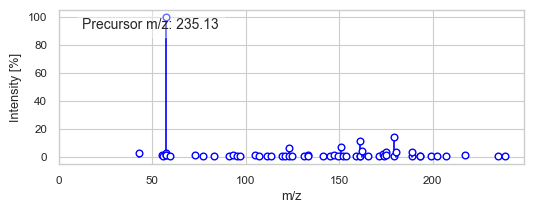

[22:05:58] SMILES Parse Error: syntax error while parsing: None
[22:05:58] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

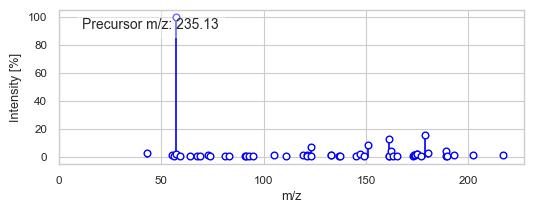

[22:05:58] SMILES Parse Error: syntax error while parsing: None
[22:05:58] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

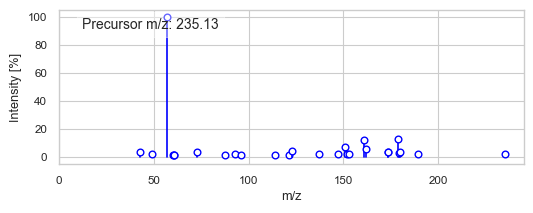

[22:05:58] SMILES Parse Error: syntax error while parsing: None
[22:05:58] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

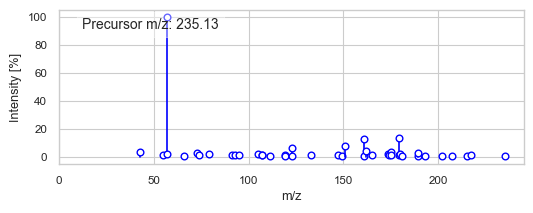

[22:05:58] SMILES Parse Error: syntax error while parsing: None
[22:05:58] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

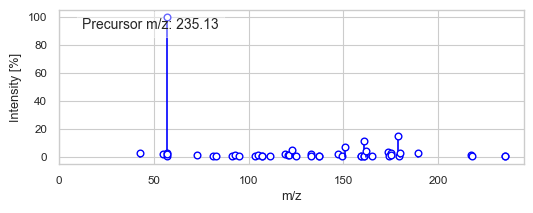

[22:05:58] SMILES Parse Error: syntax error while parsing: None
[22:05:58] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

In [8]:
for raw_i in small_idxs:
    i = int(raw_i)
    msdata.at(i, plot_mol=True)

By visually inspecting these five spectra, you observe that all have **nearly identical fragmentation patterns**.  
This confirms that the **LSH deduplication** groups near-duplicate spectra together.

Further, to confirm that the spectra in our chosen cluster are truly near-duplicates, we compute the **pairwise similarity** between all spectra in the cluster using the **modified cosine similarity** metric.  

In [9]:
cos_sim = PeakListModifiedCosine()
sim_mat_small = cos_sim.compute_pairwise(
    specs    = specs[small_idxs.astype(int)],
    prec_mzs = msdata.get_values('precursor_mz')[small_idxs.astype(int)],
    avg      = False
)
print("▶ Small cluster pairwise matrix:\n", sim_mat_small)


▶ Small cluster pairwise matrix:
 [[1.         0.99862793 0.99477183 0.9985617  0.9990396 ]
 [0.99862793 1.         0.994302   0.9980678  0.99814568]
 [0.99477183 0.994302   1.         0.99442714 0.99494768]
 [0.9985617  0.9980678  0.99442714 1.         0.99823865]
 [0.9990396  0.99814568 0.99494768 0.99823865 1.        ]]


The resulting matrix shows the **cosine similarity score** for every pair of spectra in the cluster.  
The **diagonal values** are all exactly **1**, since each spectrum is perfectly identical to itself.  
The **off-diagonal scores** indicate the similarity between different spectra in the cluster, scores close to **1** confirm that all spectra within this cluster are indeed **highly similar or even identical**.

## 2.6 Investigating larger clusters

To further validate the performance of **LSH deduplication**, we examine a larger cluster, one containing **50 or more spectra**.  
We first identify a **hash (cluster)** with a size in our target range (e.g., **50 to 200 spectra**):

In [10]:
counts = pd.Series(hashes).value_counts()
target = counts[(counts >= 50) & (counts <= 200)]
assert not target.empty, "No cluster in the desired size range found!"

# Select the first such cluster
cluster_hash = target.index[0]
cluster_size = target.iloc[0]
print(f"Selected hash {cluster_hash} with cluster size = {cluster_size}")

# Indices of all spectra in this cluster
i_idxs = np.where(hashes == cluster_hash)[0]

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_95811/974672857.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = pd.Series(hashes).value_counts()


Selected hash b'27d54b33fc782095d6c75cffe721f7173876722dfa00a4c5050f945d582afdca' with cluster size = 88


We now compute the pairwise modified cosine similarity for all spectra within this cluster:


In [11]:
cluster_specs = specs[i_idxs]
cluster_prec  = msdata.get_prec_mzs()[i_idxs]

cos_sim = PeakListModifiedCosine()
sim_mat = cos_sim.compute_pairwise(
    specs    = cluster_specs,
    prec_mzs = cluster_prec,
    avg      = False
)
print("Pairwise modified‑cosine matrix shape:", sim_mat.shape)

Pairwise modified‑cosine matrix shape: (88, 88)


### Visualizing similarity: histogram and kde

We visualize the distribution of **dissimilarities** (`1 – cosine similarity`) across all unique spectrum pairs in the cluster:

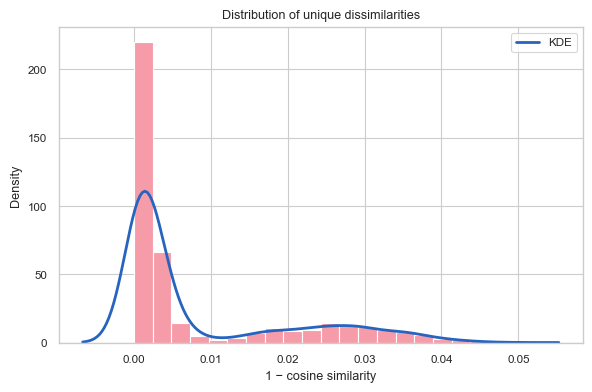

In [12]:
plot_dissimilarity_hist_kde(sim_mat)

For this large cluster, the vast majority of **pairwise dissimilarities** cluster near **0**, with a **maximum difference of 0.05**.  
In other words, even in large clusters, **LSH groups spectra that are extremely similar**, with only minor deviations.

## 2.7 Saving deduplicated data

After **LSH-based deduplication**, we want to keep only **one representative spectrum** from each cluster.  
This ensures that we are removing redundancy from the dataset before downstream **machine learning** or **library matching**.


In [13]:
# Build a DataFrame mapping each spectrum to its hash
df_map = pd.DataFrame({
    'hash': hashes,
    'scan_index': np.arange(len(hashes))
})
print("▶ Before dedupe, spectra count:", len(df_map))

▶ Before dedupe, spectra count: 4758


Next, we drop duplicates by keeping only the **first spectrum** for each unique hash:

In [14]:
df_map = df_map.drop_duplicates(subset=['hash'])
keep_idxs = np.sort(df_map['scan_index'].values)
print("▶ After dedupe, spectra count:", len(keep_idxs))

▶ After dedupe, spectra count: 2799


Finally, we write out the **deduplicated set** to a new `.hdf5` file:

In [15]:
out_h5 = h5_path.with_name(h5_path.stem + "_dedup.hdf5")
msdata_dedup = msdata.form_subset(keep_idxs, out_pth=out_h5)
print("▶ Saved deduplicated HDF5 to", out_h5)

▶ Saved deduplicated HDF5 to /Users/macbook/CODE/DreaMS_MIMB/data/Piper_sirius_all_annotated_high_quality_dedup.hdf5


You will use this deduplicated HDF5 file as the input for the next tutorial:  
`3_library_matching.ipynb`, where we perform **spectral library searches** and **annotation**.

---

## 2.8 LSH Validation on MassSpecGym

To further investigate and **prove the capability of LSH**,  
we will repeat the deduplication experiment on the **MassSpecGym** dataset.  

MassSpecGym contains **annotated** mass spectra, which makes it ideal for validation —  
after clustering, we can directly inspect whether spectra assigned to the same LSH cluster correspond to the **same or closely related compounds**.

In [4]:
msg_path      = PROJECT_ROOT / "data" / "massspecgym" / "MassSpecGym.mgf"
h5_path   = msg_path.with_name(msg_path.stem + ".hdf5")

In [5]:
if h5_path.exists():
    # If the HDF5 already exists, load it directly (this is fastest)
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    # If not, convert from the original file and cache the result as HDF5
    msdata = MSData.load(
        msg_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset MassSpecGym into memory (231104 spectra)...


In [6]:
specs = msdata.get_spectra()

lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)
hashes   = lsh_proj.compute(specs)

print(f"▶ Computed {len(hashes)} hashes; example hash: {hashes[0]!r}")

Computing LSHs: 100%|██████████| 231104/231104 [01:22<00:00, 2809.91it/s]


▶ Computed 231104 hashes; example hash: b'd1595b0fc87e45da6d813214f3f1cf26427e117d0c5c353b9f7f0ba4cefe0e2a'


In [7]:
ls     = pd.Series(hashes)
lsh_counts = ls.value_counts()

print("▶ Total unique hashes (clusters):", lsh_counts.size)
print("▶ Top 5 cluster sizes:")
print(lsh_counts.head())

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_11577/3687234620.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lsh_counts = ls.value_counts()


▶ Total unique hashes (clusters): 133471
▶ Top 5 cluster sizes:
b'bfae93ce054b4edc7aa794552cf5223a8c160080e7c8a7b02b6fe3fe8db2f8ee'    6339
b'5b3cff2b5c34fa13f93a8f47abd4a6582ddb49cc5625b368e9d1aba7e5c90d5a'     375
b'36235fd6ed50565f2733dc3de3c9291e1b077d730eef162c6f0ad9c557c56ba5'     248
b'b56df9a9acc1c00ee8ae8f0f407c717da687294d91c3b19fe278fdb03933d7e0'     247
b'670c7ff542d5d07ac07a9b7fd90a58f0aa23d34bcbafec5adab463f33692a67d'     234
Name: count, dtype: int64


/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_11577/4168792866.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lsh_counts = pd.Series(hashes).value_counts()


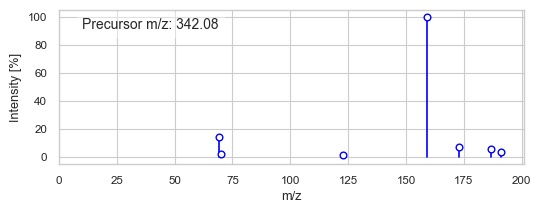

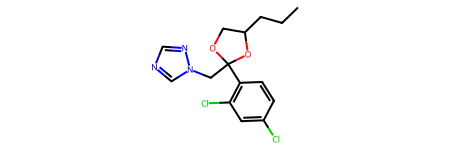

{'COLLISION_ENERGY': 40.0, 'FOLD': 'train', 'FORMULA': 'C15H17Cl2N3O2', 'IDENTIFIER': 'MassSpecGymID0020702', 'INCHIKEY': 'STJLVHWMYQXCPB', 'INSTRUMENT_TYPE': 'QTOF', 'PARENT_MASS': 341.069824, 'PRECURSOR_FORMULA': 'C15H18Cl2N3O2', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 342.0771, 'smiles': 'CCCC1COC(O1)(CN2C=NC=N2)C3=C(C=C(C=C3)Cl)Cl'}


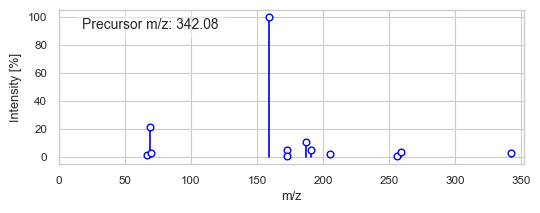

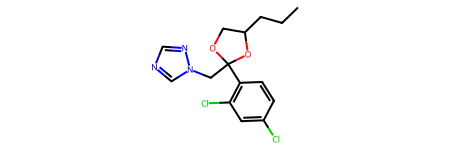

{'COLLISION_ENERGY': 30.786938999999997, 'FOLD': 'train', 'FORMULA': 'C15H17Cl2N3O2', 'IDENTIFIER': 'MassSpecGymID0020706', 'INCHIKEY': 'STJLVHWMYQXCPB', 'INSTRUMENT_TYPE': 'Orbitrap', 'PARENT_MASS': 341.069824, 'PRECURSOR_FORMULA': 'C15H18Cl2N3O2', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 342.0771, 'smiles': 'CCCC1COC(O1)(CN2C=NC=N2)C3=C(C=C(C=C3)Cl)Cl'}


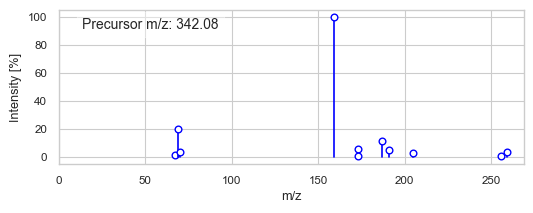

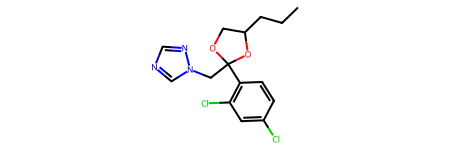

{'COLLISION_ENERGY': 30.786938999999997, 'FOLD': 'train', 'FORMULA': 'C15H17Cl2N3O2', 'IDENTIFIER': 'MassSpecGymID0020718', 'INCHIKEY': 'STJLVHWMYQXCPB', 'INSTRUMENT_TYPE': 'Orbitrap', 'PARENT_MASS': 341.069824, 'PRECURSOR_FORMULA': 'C15H18Cl2N3O2', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 342.0771, 'smiles': 'CCCC1COC(O1)(CN2C=NC=N2)C3=C(C=C(C=C3)Cl)Cl'}


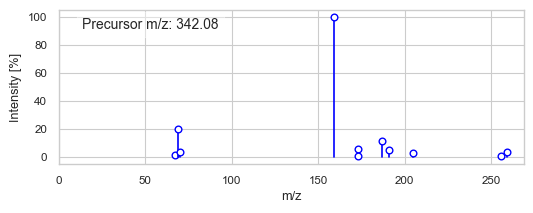

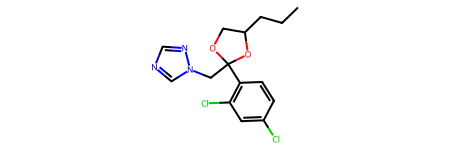

{'COLLISION_ENERGY': 30.786938999999997, 'FOLD': 'train', 'FORMULA': 'C15H17Cl2N3O2', 'IDENTIFIER': 'MassSpecGymID0020758', 'INCHIKEY': 'STJLVHWMYQXCPB', 'INSTRUMENT_TYPE': 'Orbitrap', 'PARENT_MASS': 341.069824, 'PRECURSOR_FORMULA': 'C15H18Cl2N3O2', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 342.0771, 'smiles': 'CCCC1COC(O1)(CN2C=NC=N2)C3=C(C=C(C=C3)Cl)Cl'}


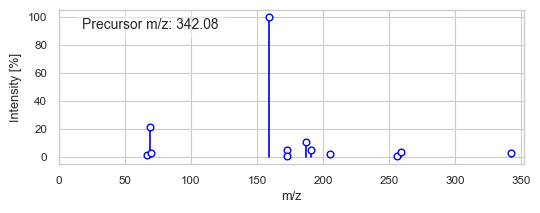

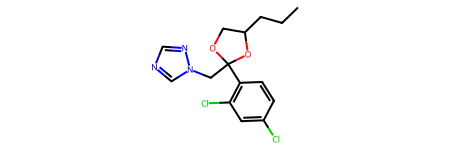

{'COLLISION_ENERGY': 30.786938999999997, 'FOLD': 'train', 'FORMULA': 'C15H17Cl2N3O2', 'IDENTIFIER': 'MassSpecGymID0020764', 'INCHIKEY': 'STJLVHWMYQXCPB', 'INSTRUMENT_TYPE': 'Orbitrap', 'PARENT_MASS': 341.069824, 'PRECURSOR_FORMULA': 'C15H18Cl2N3O2', 'SIMULATION_CHALLENGE': 'True', 'adduct': '[M+H]+', 'precursor_mz': 342.0771, 'smiles': 'CCCC1COC(O1)(CN2C=NC=N2)C3=C(C=C(C=C3)Cl)Cl'}


In [55]:
# Pick some LSH forming a cluster of 5 spectra
lsh_counts = pd.Series(hashes).value_counts()
lsh_i = lsh_counts[lsh_counts == 5].index[703]
idx = np.where(hashes == lsh_i)[0]

# Display clustered spectra
for i in idx:
    print(msdata.at(int(i), plot_mol=True))

As we can see, all spectra correspond to the same compound measured under different MS conditions (e.g., QTOF and Orbitrap).  
Notice that the LSH algorithm is **robust to noise**, which is evident from the signals at > 250 Da in some spectra. We can further verify that **all pairs of spectra** have high *modified cosine similarities*.

In [10]:
cos_sim = PeakListModifiedCosine()
cos_sim.compute_pairwise(specs=msdata['spectrum'][idx], prec_mzs=msdata['precursor_mz'][idx], avg=False)

array([[1.        , 0.99736452, 0.9983912 , 0.9983236 , 0.99744844],
       [0.99736452, 1.        , 0.99749553, 0.9975831 , 0.99750836],
       [0.9983912 , 0.99749553, 1.        , 0.99850248, 0.9978465 ],
       [0.9983236 , 0.9975831 , 0.99850248, 1.        , 0.99751652],
       [0.99744844, 0.99750836, 0.9978465 , 0.99751652, 1.        ]])

Note that LSH clustering of mass spectra is designed to be a high-precision, low-recall algorithm.  
This means that while the clustering allows for the fast detection of near-duplicate spectra, it is conceptually too simple to cluster all different spectra of the same compound or to perfectly approximate modified cosine similarity.

The compound representing the selected cluster is present **46 times** in the dataset.  
Let’s look into all spectra of this compound.

In [56]:
idx_inchi = np.where(np.array(msdata['INCHIKEY']) == 'RHMXXJGYXNZAPX')[0]
idx_inchi.shape

(46,)

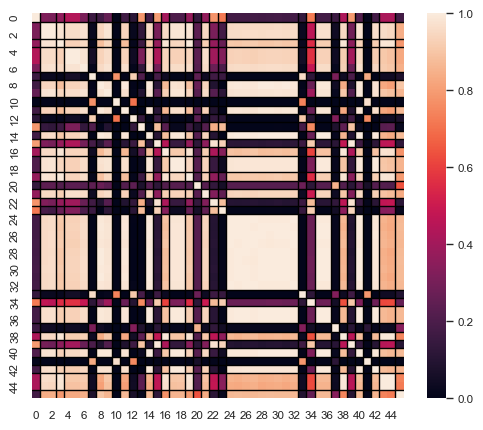

In [21]:
# Sort idx_inchi by their lshs
idx_inchi = idx_inchi[np.argsort(hashes[idx_inchi])]
idx_inchi

# Plot heatmap of pairwise modified cosine similarities
init_plotting(figsize=(6, 5))
sns.heatmap(cos_sim.compute_pairwise(specs=msdata['spectrum'][idx_inchi], prec_mzs=msdata['precursor_mz'][idx_inchi], avg=False), linewidth=0)

# Draw LSH boundaries
for i, (a, b) in enumerate(zip(hashes[idx_inchi], hashes[idx_inchi][1:])):
    if a != b:
        plt.axvline(i + 1, color='black', linewidth=1)
        plt.axhline(i + 1, color='black', linewidth=1)

plt.show()

Each cell (framed with black lines) of the heatmap represents a separate LSH cluster corresponding to the same compound, with colors indicating modified cosine similarities.  
We observe that the spectra of the same compound are fragmented into different clusters, and not all highly similar pairs are connected, indicating low recall.  
However, all intra-cluster similarities are very high, demonstrating high precision.

Ultimately, we clustered **231,104 spectra** in one minute (on a MacBook M1), avoiding pairwise similarity calculations and achieving no false positives with respect to modified cosine similarity (a more systematic evaluation is in the next section).  
This is the main advantage of LSH compared to other methods.  
For a more systematic evaluation, please refer to our paper or to this [notebook](https://github.com/pluskal-lab/DreaMS/blob/main/experiments/clustering/clustering_evaluation.ipynb).